In [1]:
# Standard Python libraries
from __future__ import print_function, division
from collections import OrderedDict
import warnings
import os
import sys
import uuid

# http://www.numpy.org/
import numpy as np

# http://pandas.pydata.org/
import pandas as pd

# https://scipy.org/
from scipy.interpolate import griddata, RectBivariateSpline, Rbf
from scipy.optimize import minimize, minimize_scalar

# http://matplotlib.org/
import matplotlib.pyplot as plt
from matplotlib import cm

# https://github.com/usnistgov/atomman
import atomman as am
import atomman.unitconvert as uc
import atomman.defect.peierlsnabarro as pn

# https://github.com/usnistgov/iprPy
import iprPy

In [2]:
# Define calc_style and record_style
calc_style = 'dislocation_Peierls_Nabarro'
record_style = 'calculation_dislocation_Peierls_Nabarro'

In [3]:
inputfile = """
#Run script for dislocation_Peierls_Nabarro.py

#Initial system configuration to load
load_file                   Ercolessi_Al/1/78017ce9-6336-4c86-b6ad-a53e62510e68.xml
load_style                  system_model
load_options                key relaxed-atomic-system
symbols                     
box_parameters              

#System manipulations
x_axis                      
y_axis                      
z_axis                      

#Defect parameters
dislocation_model           A1--Cu--fcc--111-edge.json
gammasurface_model          Ercolessi_Al/1/4bce5619-5de9-4f09-888f-fd3050447ec7.xml

#Elastic constants parameters 
elasticconstants_model      Ercolessi_Al/1/78017ce9-6336-4c86-b6ad-a53e62510e68.xml
bulk_modulus
poisson

#Units that input/output values are in
length_unit                 
pressure_unit               
energy_unit                 
force_unit                  

#Run parameters
xmax                         10 nm
xstep
xnum                         101
minimize_style               Powell
minimize_steps               
cutoffelastic
tau_xz
tau_yz
tau_zz
alpha
beta
cdiffelastic
cdiffgradient
halfwidth

"""
with open('calc_dislocation_Peierls_Nabarro.in', 'w') as f:
    f.write(inputfile)
    
args = ['calc_dislocation_Peierls_Nabarro.in']

In [4]:
# Read input file in as dictionary
with open(args[0]) as f:
    input_dict = iprPy.tools.parseinput(f, allsingular=True)
    
input_dict

{'dislocation_model': 'A1--Cu--fcc--111-edge.json',
 'elasticconstants_model': 'Ercolessi_Al/1/78017ce9-6336-4c86-b6ad-a53e62510e68.xml',
 'gammasurface_model': 'Ercolessi_Al/1/4bce5619-5de9-4f09-888f-fd3050447ec7.xml',
 'load_file': 'Ercolessi_Al/1/78017ce9-6336-4c86-b6ad-a53e62510e68.xml',
 'load_options': 'key relaxed-atomic-system',
 'load_style': 'system_model',
 'minimize_style': 'Powell',
 'xmax': '10 nm',
 'xnum': '101'}

In [5]:
def process_input(input_dict, UUID=None, build=True):
    """
    Processes str input parameters, assigns default values if needed, and
    generates new, more complex terms as used by the calculation.
    
    Parameters
    ----------
    input_dict :  dict
        Dictionary containing the calculation input parameters with string
        values.  The allowed keys depends on the calculation style.
    UUID : str, optional
        Unique identifier to use for the calculation instance.  If not 
        given and a 'UUID' key is not in input_dict, then a random UUID4 
        hash tag will be assigned.
    build : bool, optional
        Indicates if all complex terms are to be built.  A value of False
        allows for default values to be assigned even if some inputs 
        required by the calculation are incomplete.  (Default is True.)
    """
    
    # Set calculation UUID
    if UUID is not None: 
        input_dict['calc_key'] = UUID
    else: 
        input_dict['calc_key'] = input_dict.get('calc_key', str(uuid.uuid4()))
    
    # Set default input/output units
    iprPy.input.units(input_dict)
    
    # These are calculation-specific default strings
    input_dict['minimize_style'] = input_dict.get('minimize_style', 'Powell')
    
    # These are calculation-specific default booleans
    input_dict['cdiffelastic'] = iprPy.input.boolean(input_dict.get('cdiffelastic', False))
    input_dict['cdiffgradient'] = iprPy.input.boolean(input_dict.get('cdiffgradient', True))
    input_dict['fullstress'] = iprPy.input.boolean(input_dict.get('fullstress', True))
    
    # These are calculation-specific default integers
    if 'xnum' in input_dict:
        input_dict['xnum'] = int(input_dict['xnum'])
    else:
        input_dict['xnum'] = None
    if 'minimize_steps' in input_dict:
        input_dict['minimize_steps'] = int(input_dict['minimize_steps'])
    else:
        input_dict['minimize_steps'] = None
    
    # These are calculation-specific default unitless floats
    input_dict['beta'] = float(input_dict.get('beta', 0.0))
    
    # These are calculation-specific default floats with units
    input_dict['tau_xz'] = iprPy.input.value(input_dict, 'tau_xz',
                                    default_unit=input_dict['pressure_unit'],
                                    default_term='0.0 GPa')
    input_dict['tau_yz'] = iprPy.input.value(input_dict, 'tau_yz',
                                    default_unit=input_dict['pressure_unit'],
                                    default_term='0.0 GPa')
    input_dict['tau_zz'] = iprPy.input.value(input_dict, 'tau_zz',
                                    default_unit=input_dict['pressure_unit'],
                                    default_term='0.0 GPa')
    if 'xstep' in input_dict:
        input_dict['xstep'] = iprPy.input.value(input_dict, 'xstep',
                                    default_unit=input_dict['length_unit'])
    else:
        input_dict['xstep'] = None
    if 'xmax' in input_dict:
        input_dict['xmax'] = iprPy.input.value(input_dict, 'xmax',
                                    default_unit=input_dict['length_unit'])
    else:
        input_dict['xmax'] = None
    if 'halfwidth' in input_dict:
        input_dict['halfwidth'] = iprPy.input.value(input_dict, 'halfwidth',
                                    default_unit=input_dict['length_unit'])
    else:
        input_dict['halfwidth'] = None
    if 'cutoffelastic' in input_dict:
        input_dict['cutoffelastic'] = iprPy.input.value(input_dict, 'cutoffelastic',
                                    default_unit=input_dict['length_unit'])
    else:
        input_dict['cutoffelastic'] = None
    
    # Process stress terms
    txz = input_dict['tau_xz']
    tyz = input_dict['tau_yz']
    tzz = input_dict['tau_zz']
    input_dict['tau'] = np.array([[0.0, 0.0, txz],
                                  [0.0, 0.0, tyz],
                                  [txz, tyz, tzz]])
    
    # Process alpha term
    alpha = input_dict.get('alpha', '0.0').split()
    for i in range(len(alpha)):
        alpha[i] = float(alpha[i])
    input_dict['alpha'] = alpha
    
    # Load ucell system
    iprPy.input.systemload(input_dict, build=build)
    
    # Load dislocation parameters
    iprPy.input.dislocationmonopole(input_dict)
    
    # Load system manipulate to process parameters without building
    iprPy.input.systemmanipulate(input_dict, build=False)
    
    # Load elastic constants
    iprPy.input.elasticconstants(input_dict, build=build)
    
    # Load gamma surface
    iprPy.input.gammasurface(input_dict, build=build)

In [6]:
process_input(input_dict, *args[1:])

input_dict

{'C': <atomman.core.ElasticConstants.ElasticConstants at 0x9957e48>,
 'alpha': [0.0],
 'atomshift': u' 0.00 0.25 0.00',
 'axes': array([[ 1.,  0., -1.],
        [ 1.,  1.,  1.],
        [ 1., -2.,  1.]]),
 'beta': 0.0,
 'boundarywidth': 12.096219999989998,
 'box_parameters': None,
 'burgersvector': array([ 2.01603667,  0.        , -2.01603667]),
 'calc_key': '6d77fecc-89db-451c-9030-35d31b9aa788',
 'cdiffelastic': False,
 'cdiffgradient': True,
 'cutoffelastic': None,
 'dislocation_boundaryshape': 'circle',
 'dislocation_boundarywidth': 3.0,
 'dislocation_burgersvector': u' 0.5  0.0 -0.5',
 'dislocation_model': DataModelDict([(u'key',
                 u'd59f2382-17e5-4fbd-b398-407c75e6009a'),
                (u'id', u'A1--Cu--fcc--111-edge'),
                (u'character', u'edge'),
                (u'Burgers-vector', u'a/2[ 1, 0,-1]'),
                (u'slip-plane', [1L, 1L, 1L]),
                (u'line-direction', [1L, -2L, 1L]),
                (u'system-family', u'A1--Cu--fcc'),


In [7]:
def peierlsnabarro(C, axes, burgers, gamma, cutoffelastic=None, 
                   tau=np.zeros((3,3)), alpha=0.0, beta=0.0,
                   cdiffelastic=False, cdiffgradient=True,
                   fullstress=True, halfwidth=None,
                   xnum=None, xmax=None, xstep=None, 
                   min_method='Powell', min_steps=None):
    """
    Solves a Peierls-Nabarro dislocation model.
    """
    
    # Solve Stroh method for dislocation
    stroh = am.defect.Stroh(C, burgers, axes=axes)
    Kij = stroh.K_tensor
    
    # Transform burgers to axes
    T = am.tools.axes_check(axes)
    b = T.dot(burgers)
    
    # Generate x coordinates and dx
    x, dx = pn.xgenerate(xmax=xmax, step=xstep, num=xnum)
    
    # Identify optimum arctan halfwidth
    if halfwidth is None:
        def E_disl_halfwidth(h, x, b, gamma, axes, Kij):
            disreg = pn.disregistry(x, b, halfwidth=h)
            return pn.total_energy(x, disreg, gamma, axes, Kij)
        res = minimize_scalar(E_disl_halfwidth, args=(x, b, gamma, axes, Kij),
                              method='bounded', bounds=[0.1, 100])
        halfwidth = res.x 
        print('Initial halfwidth =', halfwidth)
    
    # Generate initial disregistry guess
    idisreg = pn.disregistry(x, b, halfwidth)
    
    # Minimize disregistry
    fdisreg = pn.minimize_disregistry(x, idisreg, gamma, axes, Kij,
                                      tau=tau, alpha=alpha, beta=beta,
                                      cutoffelastic=cutoffelastic, burgers=b,
                                      fullstress=fullstress, 
                                      cdiffelastic=cdiffelastic, cdiffgradient=cdiffgradient,
                                      min_method=min_method, min_steps=min_steps)
    
    # Compile disregistry results
    disreg_data = OrderedDict()
    disreg_data['x'] = x
    disreg_data['idisreg[0]'] = idisreg[:,0]
    disreg_data['idisreg[1]'] = idisreg[:,1]
    disreg_data['idisreg[2]'] = idisreg[:,2]
    
    idensity = np.zeros_like(idisreg)
    idensity[1:] = pn.disldensity(x, idisreg)
    disreg_data['idensity[0]'] = idensity[:,0]
    disreg_data['idensity[1]'] = idensity[:,1]
    disreg_data['idensity[2]'] = idensity[:,2]
    
    disreg_data['fdisreg[0]'] = fdisreg[:,0]
    disreg_data['fdisreg[1]'] = fdisreg[:,1]
    disreg_data['fdisreg[2]'] = fdisreg[:,2]
    
    fdensity = np.zeros_like(fdisreg)
    fdensity[1:] = pn.disldensity(x, fdisreg)
    disreg_data['fdensity[0]'] = fdensity[:,0]
    disreg_data['fdensity[1]'] = fdensity[:,1]
    disreg_data['fdensity[2]'] = fdensity[:,2]
    
    disreg_data = pd.DataFrame(disreg_data)
    
    # Initialize results dict
    results_dict = {}    
    results_dict['stroh_Kij'] = Kij
    results_dict['deltax'] = dx
    results_dict['halfwidth_0'] = halfwidth
    results_dict['E_misfit'] = pn.misfit_energy(x, fdisreg, gamma, axes)
    results_dict['E_elastic'] = pn.elastic_energy(x, fdisreg, Kij, cutoff=cutoffelastic, 
                                                  burgers=b, cdiff=cdiffelastic)
    results_dict['E_stress'] = pn.stress_energy(x, fdisreg, tau=tau, full=fullstress)
    results_dict['E_gradient'] = pn.gradient_energy(x, fdisreg, beta=beta, cdiff=cdiffgradient)
    results_dict['E_nonlocal'] = pn.nonlocal_energy(x, fdisreg, alpha=alpha)
    results_dict['E_total'] = pn.total_energy(x, fdisreg, gamma, axes, Kij,
                                              tau=tau, alpha=alpha, beta=beta,
                                              cutoffelastic=cutoffelastic, burgers=b,
                                              fullstress=fullstress, 
                                              cdiffelastic=cdiffelastic, cdiffgradient=cdiffgradient)
    results_dict['disreg_data'] = disreg_data   
    
    return results_dict

In [8]:
results_dict = peierlsnabarro(input_dict['C'], 
                              input_dict['axes'], 
                              input_dict['burgersvector'],
                              input_dict['gamma'], 
                              cutoffelastic=input_dict['cutoffelastic'], 
                              tau=input_dict['tau'], 
                              alpha=input_dict['alpha'], 
                              beta=input_dict['beta'],
                              cdiffelastic=input_dict['cdiffelastic'], 
                              cdiffgradient=input_dict['cdiffgradient'],
                              fullstress=input_dict['fullstress'], 
                              halfwidth=input_dict['halfwidth'],
                              xnum=input_dict['xnum'],
                              xstep=input_dict['xstep'],
                              xmax=input_dict['xmax'],
                              min_method=input_dict['minimize_style'],
                              min_steps=input_dict['minimize_steps'])

results_dict.keys()

Initial halfwidth = 2.18691272365


['E_misfit',
 'deltax',
 'E_nonlocal',
 'stroh_Kij',
 'E_total',
 'E_elastic',
 'E_gradient',
 'E_stress',
 'disreg_data',
 'halfwidth_0']

In [9]:
print('deltax =', uc.get_in_units(results_dict['deltax'], 'Angstrom'), 'Angstrom')

deltax = 2.0 Angstrom


In [10]:
print('halfwidth_0 =', uc.get_in_units(results_dict['halfwidth_0'], 'Angstrom'), 'Angstrom')

halfwidth_0 = 2.18691272365 Angstrom


In [11]:
print(uc.get_in_units(results_dict['stroh_Kij'], 'GPa'))

[[ 48.50216663   0.           0.        ]
 [  0.          49.01295244  -1.3446728 ]
 [  0.          -1.3446728   32.04532906]]


In [12]:
print('E_total =   ', uc.get_in_units(results_dict['E_total'], 'eV/Angstrom'), 'eV/Angstrom')
print('E_elastic = ', uc.get_in_units(results_dict['E_elastic'], 'eV/Angstrom'), 'eV/Angstrom')
print('E_misfit =  ', uc.get_in_units(results_dict['E_misfit'], 'eV/Angstrom'), 'eV/Angstrom')
print('E_stress =  ', uc.get_in_units(results_dict['E_stress'], 'eV/Angstrom'), 'eV/Angstrom')
print('E_gradient =', uc.get_in_units(results_dict['E_gradient'], 'eV/Angstrom'), 'eV/Angstrom')
print('E_nonlocal =', uc.get_in_units(results_dict['E_nonlocal'], 'eV/Angstrom'), 'eV/Angstrom')

E_total =    -0.214085473873 eV/Angstrom
E_elastic =  -0.403548926641 eV/Angstrom
E_misfit =   0.189463452768 eV/Angstrom
E_stress =   -0.0 eV/Angstrom
E_gradient = 0.0 eV/Angstrom
E_nonlocal = 0.0 eV/Angstrom


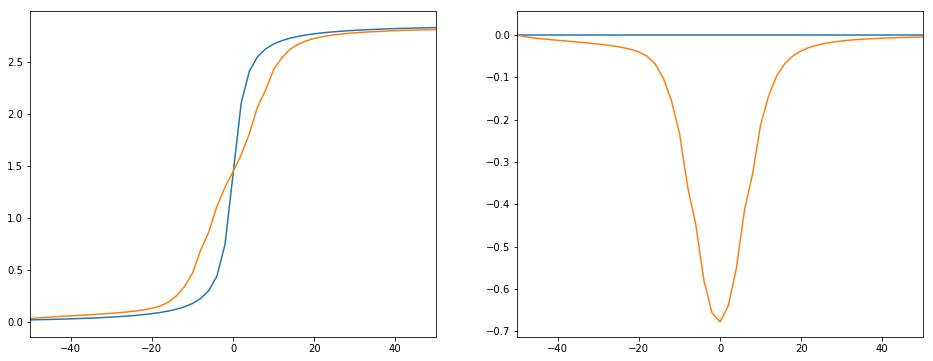

In [19]:
fig, ax = plt.subplots(ncols=2, figsize=(16,6))
ax[0].plot(results_dict['disreg_data'].x, results_dict['disreg_data']['idisreg[0]'])
ax[0].plot(results_dict['disreg_data'].x, results_dict['disreg_data']['fdisreg[0]'])
ax[0].set_xlim(-50, 50)
ax[1].plot(results_dict['disreg_data'].x, results_dict['disreg_data']['idisreg[2]'])
ax[1].plot(results_dict['disreg_data'].x, results_dict['disreg_data']['fdisreg[2]'])
ax[1].set_xlim(-50, 50)
plt.show()


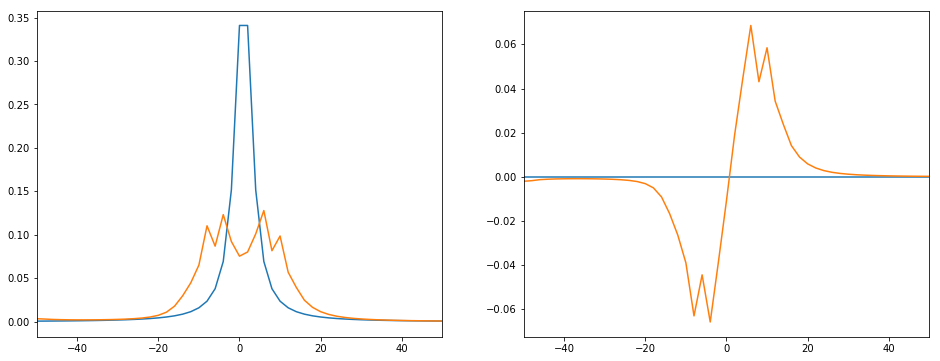

In [21]:
fig, ax = plt.subplots(ncols=2, figsize=(16,6))
ax[0].plot(results_dict['disreg_data'].x, results_dict['disreg_data']['idensity[0]'])
ax[0].plot(results_dict['disreg_data'].x, results_dict['disreg_data']['fdensity[0]'])
ax[0].set_xlim(-50, 50)
ax[1].plot(results_dict['disreg_data'].x, results_dict['disreg_data']['idensity[2]'])
ax[1].plot(results_dict['disreg_data'].x, results_dict['disreg_data']['fdensity[2]'])
ax[1].set_xlim(-50, 50)
plt.show()